**Target: Xây dựng mô hình phân loại khả năng trả nợ khoản vay của khách hàng, sau đó chuyển từ xác xuất sang điểm tín dụng. Lúc này bài toán chuyển từ dạng phân loại sang dự đoán (điểm tín dụng).**

***Ở đây, ta sẽ sử dụng 4 model chính trong bài toán này:***
- Random forest
- Decision Tree
- SVM
- KNN
- DNN
- Evaluasi hasil dengan confusion matrix, F1-score Precision Recall Accuracy & ROC AOC CURVE

### 1. Setting EVN

In [78]:
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import warnings
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import statistics
from scipy.stats import norm, skew, probplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score

### 2.Load and check data

In [79]:
import pandas as pd

file_path = 'D:\WorkSpace_Thinh1\FSS\hmeq.csv'
data = pd.read_csv(file_path)

data.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [80]:
data.shape

(5960, 13)

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


### 3. Data Preprocessing 

In [82]:
descriptive_stats = data.describe(include='all')
missing_values = data.isnull().sum()

stats_summary = pd.DataFrame(descriptive_stats)
stats_summary['Missing Values'] = missing_values

stats_summary.T 

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
BAD,5960.0,NaN,NaN,NaN,0.199497,0.399656,0.0,0.0,0.0,0.0,1.0
LOAN,5960.0,NaN,NaN,NaN,18607.969799,11207.480417,1100.0,11100.0,16300.0,23300.0,89900.0
MORTDUE,5442.0,NaN,NaN,NaN,73760.8172,44457.609458,2063.0,46276.0,65019.0,91488.0,399550.0
VALUE,5848.0,NaN,NaN,NaN,101776.048741,57385.775334,8000.0,66075.5,89235.5,119824.25,855909.0
REASON,5708,2,DebtCon,3928,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JOB,5681,6,Other,2388,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YOJ,5445.0,NaN,NaN,NaN,8.922268,7.573982,0.0,3.0,7.0,13.0,41.0
DEROG,5252.0,NaN,NaN,NaN,0.25457,0.846047,0.0,0.0,0.0,0.0,10.0
DELINQ,5380.0,NaN,NaN,NaN,0.449442,1.127266,0.0,0.0,0.0,0.0,15.0
CLAGE,5652.0,NaN,NaN,NaN,179.766275,85.810092,0.0,115.116702,173.466667,231.562278,1168.233561


In [83]:
numeric_columns = data.select_dtypes(include=['number']).columns

for col in numeric_columns:
    median_value = data[col].median()
    data[col].fillna(median_value, inplace=True)

missing_values_after_imputation = data[numeric_columns].isnull().sum()
missing_values_after_imputation

C:\Users\pc\AppData\Local\Temp\ipykernel_8976\2512750135.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(median_value, inplace=True)
C:\Users\pc\AppData\Local\Temp\ipykernel_8976\2512750135.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

In [84]:
data["REASON"] = data["REASON"].fillna("Other reason")

In [85]:
data['JOB'] = data['JOB'].fillna(data['JOB'].mode()[0])

In [86]:
categorical_columns = data.select_dtypes(include=['object']).columns

missing_values_after_imputation_categorical = data[categorical_columns].isnull().sum()
missing_values_after_imputation_categorical

REASON    0
JOB       0
dtype: int64

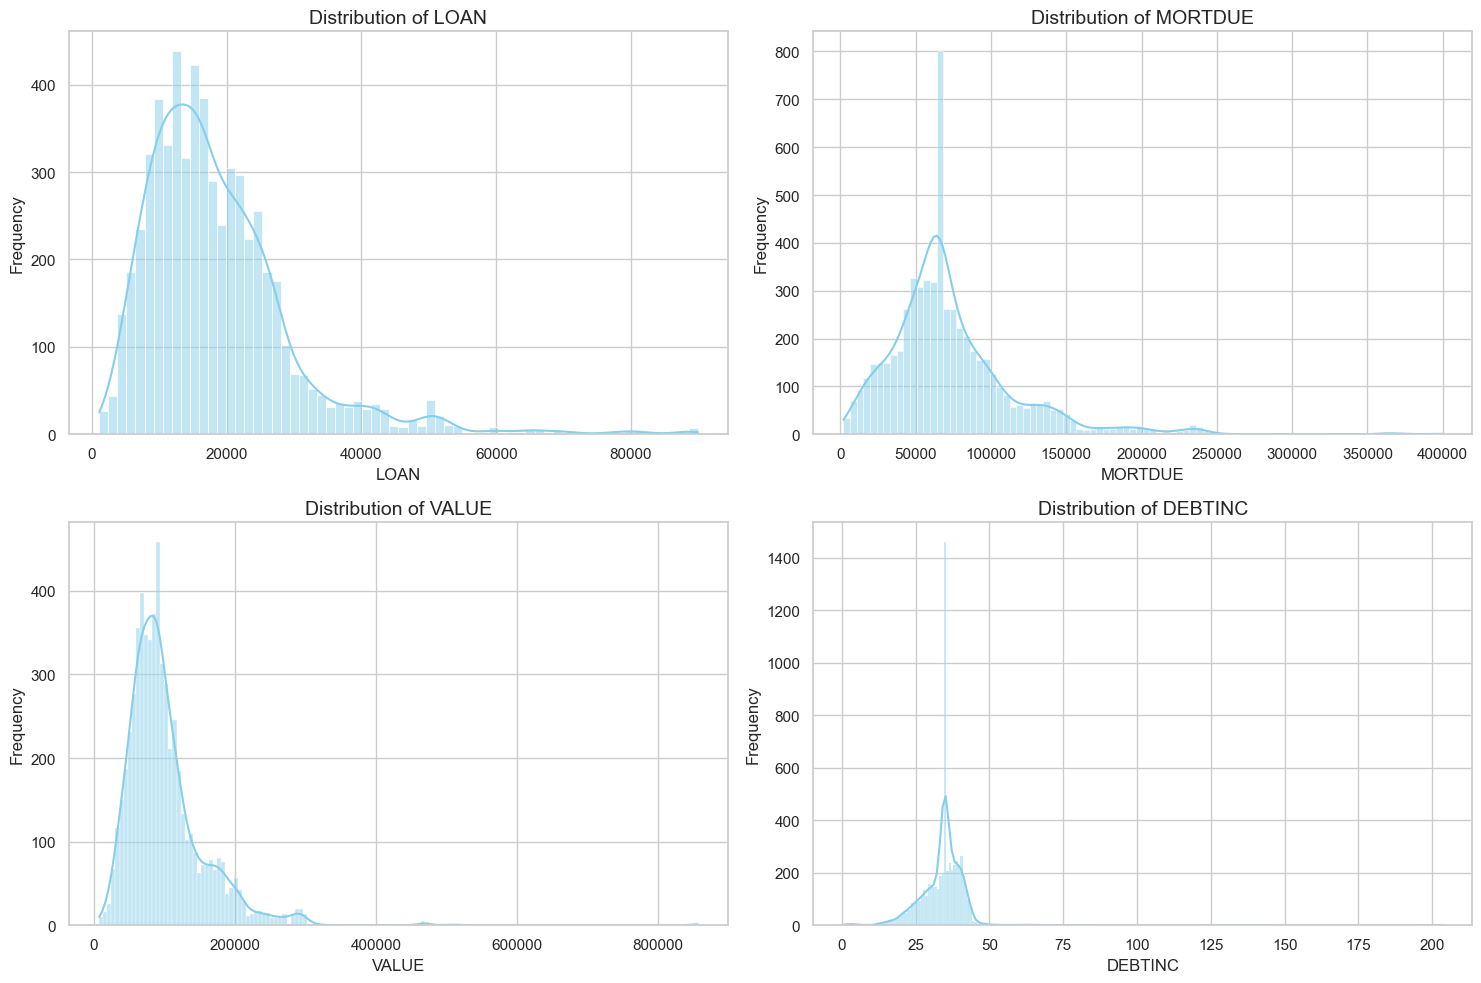

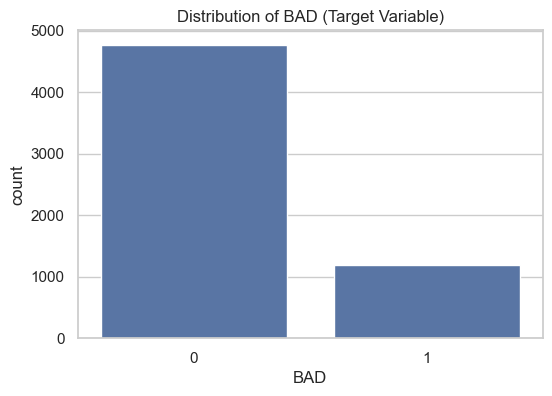

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")
numeric_cols_to_analyze = ['LOAN', 'MORTDUE', 'VALUE', 'DEBTINC']


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten() 

for i, col in enumerate(numeric_cols_to_analyze):
    sns.histplot(data[col], ax=axes[i], kde=True, color='skyblue')
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x='BAD', data=data)
plt.title('Distribution of BAD (Target Variable)')
plt.show()

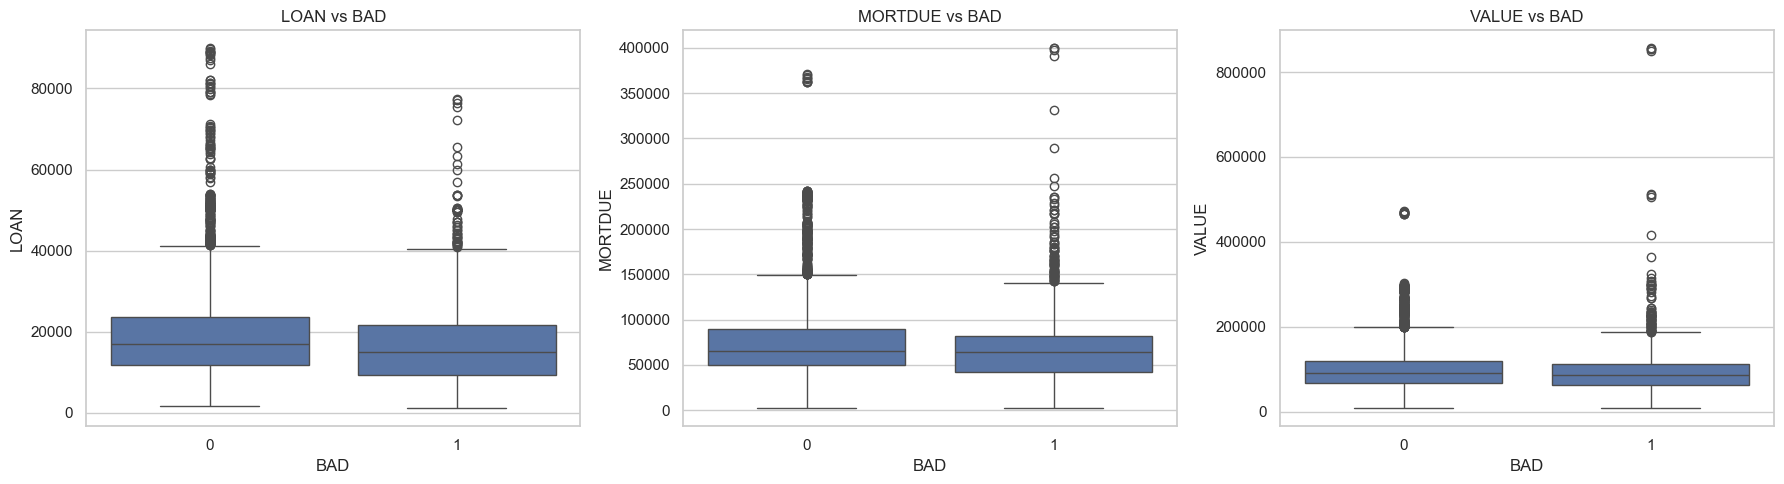

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sns.boxplot(x='BAD', y='LOAN', data=data, ax=axes[0])
axes[0].set_title('LOAN vs BAD')

sns.boxplot(x='BAD', y='MORTDUE', data=data, ax=axes[1])
axes[1].set_title('MORTDUE vs BAD')

sns.boxplot(x='BAD', y='VALUE', data=data, ax=axes[2])
axes[2].set_title('VALUE vs BAD')

plt.tight_layout()
plt.show()

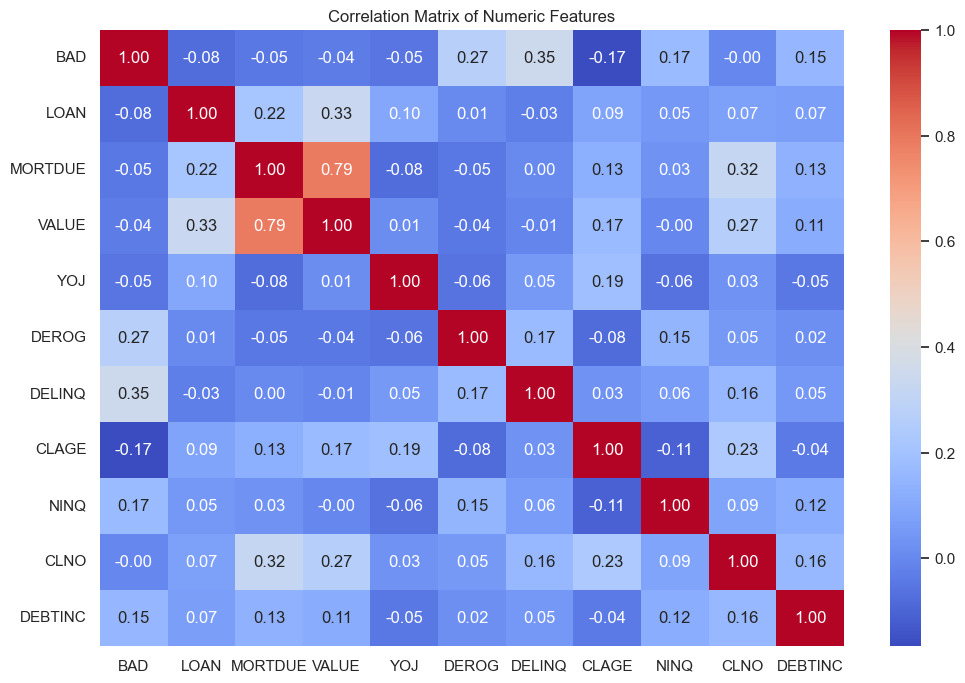

In [89]:
correlation_matrix = data[numeric_columns].corr()

# heatmap korelasi
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

In [90]:
correlations_with_bad = correlation_matrix['BAD'].sort_values(ascending=False)

correlations_with_bad

BAD        1.000000
DELINQ     0.346503
DEROG      0.269921
NINQ       0.170031
DEBTINC    0.154544
CLNO      -0.004543
VALUE     -0.036492
MORTDUE   -0.046186
YOJ       -0.053956
LOAN      -0.075099
CLAGE     -0.165614
Name: BAD, dtype: float64

In [91]:
data_encoded = pd.get_dummies(data, columns=['JOB', 'REASON'])
data_encoded.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,REASON_DebtCon,REASON_HomeImp,REASON_Other reason
0,1,1100,25860.0,39025.0,10.5,0.0,0.0,94.366667,1.0,9.0,34.818262,False,False,True,False,False,False,False,True,False
1,1,1300,70053.0,68400.0,7.0,0.0,2.0,121.833333,0.0,14.0,34.818262,False,False,True,False,False,False,False,True,False
2,1,1500,13500.0,16700.0,4.0,0.0,0.0,149.466667,1.0,10.0,34.818262,False,False,True,False,False,False,False,True,False
3,1,1500,65019.0,89235.5,7.0,0.0,0.0,173.466667,1.0,20.0,34.818262,False,False,True,False,False,False,False,False,True
4,0,1700,97800.0,112000.0,3.0,0.0,0.0,93.333333,0.0,14.0,34.818262,False,True,False,False,False,False,False,True,False


In [92]:
#Xử lí mất cân bằng

# target_balance = data['BAD'].value_counts()
# target_balance_percentage = data['BAD'].value_counts(normalize=True) * 100

# target_balance, target_balance_percentage

In [93]:
# Xử lí mất cân bằng

# from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE

# # Memisahkan fitur dan target
X = data_encoded.drop('BAD', axis=1)
y = data_encoded['BAD']

# # Membagi dataset menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Menerapkan SMOTE pada training set
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_smote, y_train_smote = X_train,y_train

# # Cek keseimbangan setelah SMOTE
# print(y_train_smote.value_counts())

### 4. Build Model

**4.1 Random Forest**

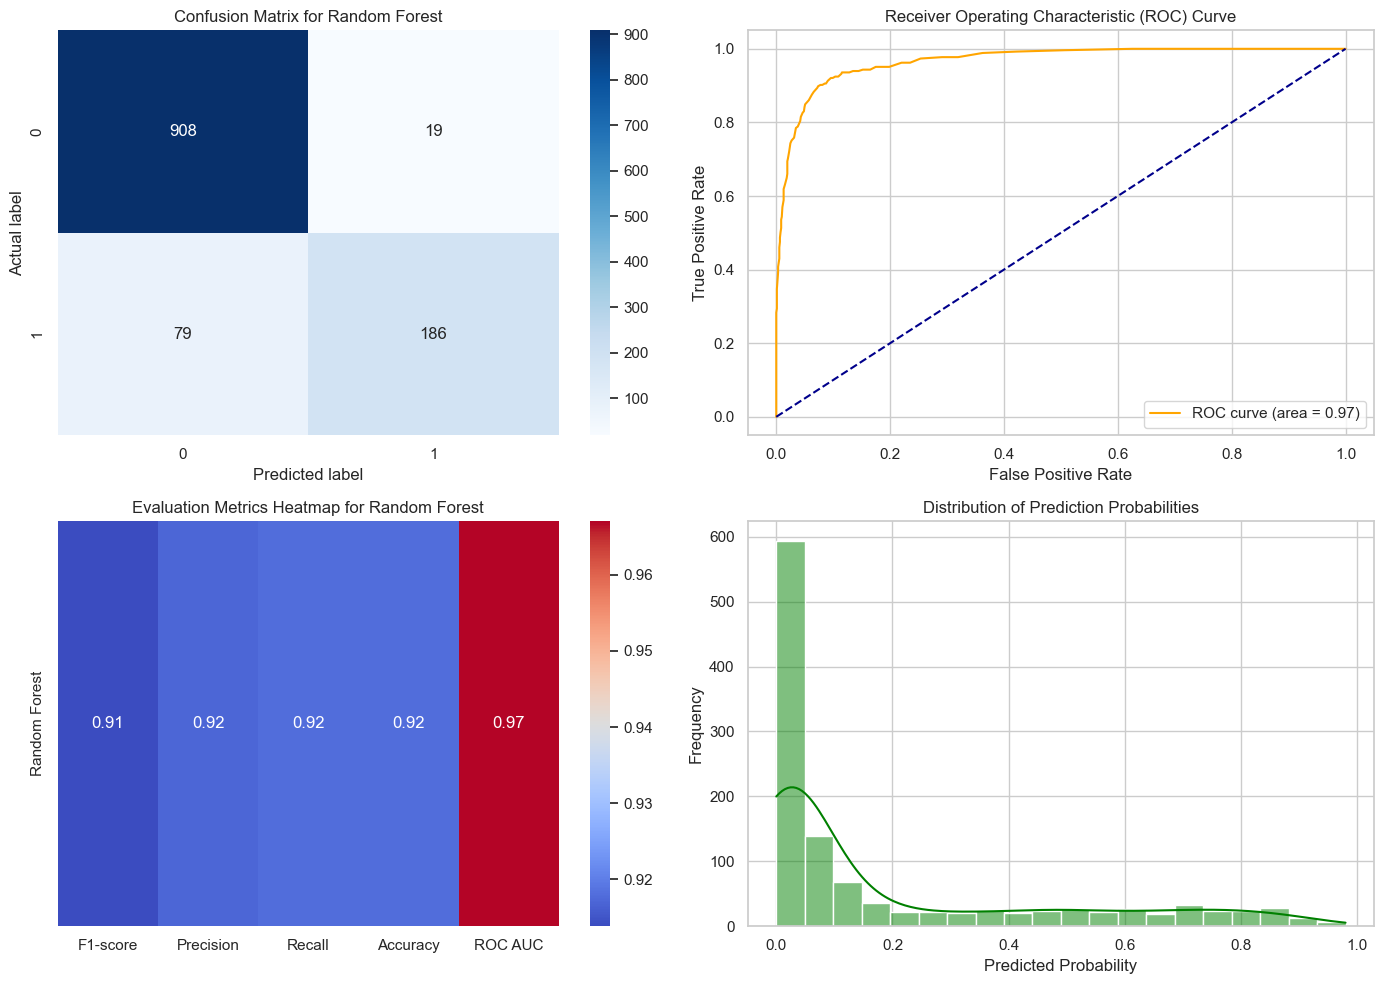

{'F1-score': 0.9138261166172849, 'Precision': 0.9171488724842166, 'Recall': 0.9177852348993288, 'Accuracy': 0.9177852348993288, 'ROC AUC': 0.9670330341332356}


In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

y_pred_rf = rf_model.predict(X_test)

rf_report = classification_report(y_test, y_pred_rf, output_dict=True)
rf_confusion_matrix = confusion_matrix(y_test, y_pred_rf)
rf_roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

rf_metrics = {
    'F1-score': rf_report['weighted avg']['f1-score'],
    'Precision': rf_report['weighted avg']['precision'],
    'Recall': rf_report['weighted avg']['recall'],
    'Accuracy': rf_report['accuracy'],
    'ROC AUC': rf_roc_auc
}

plt.figure(figsize=(14, 10))

metrics_df = pd.DataFrame([rf_metrics], index=['Random Forest'])

plt.subplot(2, 2, 1)
sns.heatmap(rf_confusion_matrix, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix for Random Forest")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.subplot(2, 2, 2)
fpr, tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {rf_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

plt.subplot(2, 2, 3)
sns.heatmap(metrics_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Evaluation Metrics Heatmap for Random Forest")

plt.subplot(2, 2, 4)
sns.histplot(rf_model.predict_proba(X_test)[:, 1], kde=True, color='green', bins=20)
plt.title('Distribution of Prediction Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
print(rf_metrics)

***Tunning model bằng Grid Search***

Fitting 5 folds for each of 90 candidates, totalling 450 fits


d:\anaconda3\envs\python310\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
68 fits failed with the following error:
Traceback (most recent call last):
  File "d:\anaconda3\envs\python310\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\anaconda3\envs\python310\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "d:\anaconda3\envs\python310\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "d:\anaconda3\envs\python310\l

Best Parameters: {'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 300}


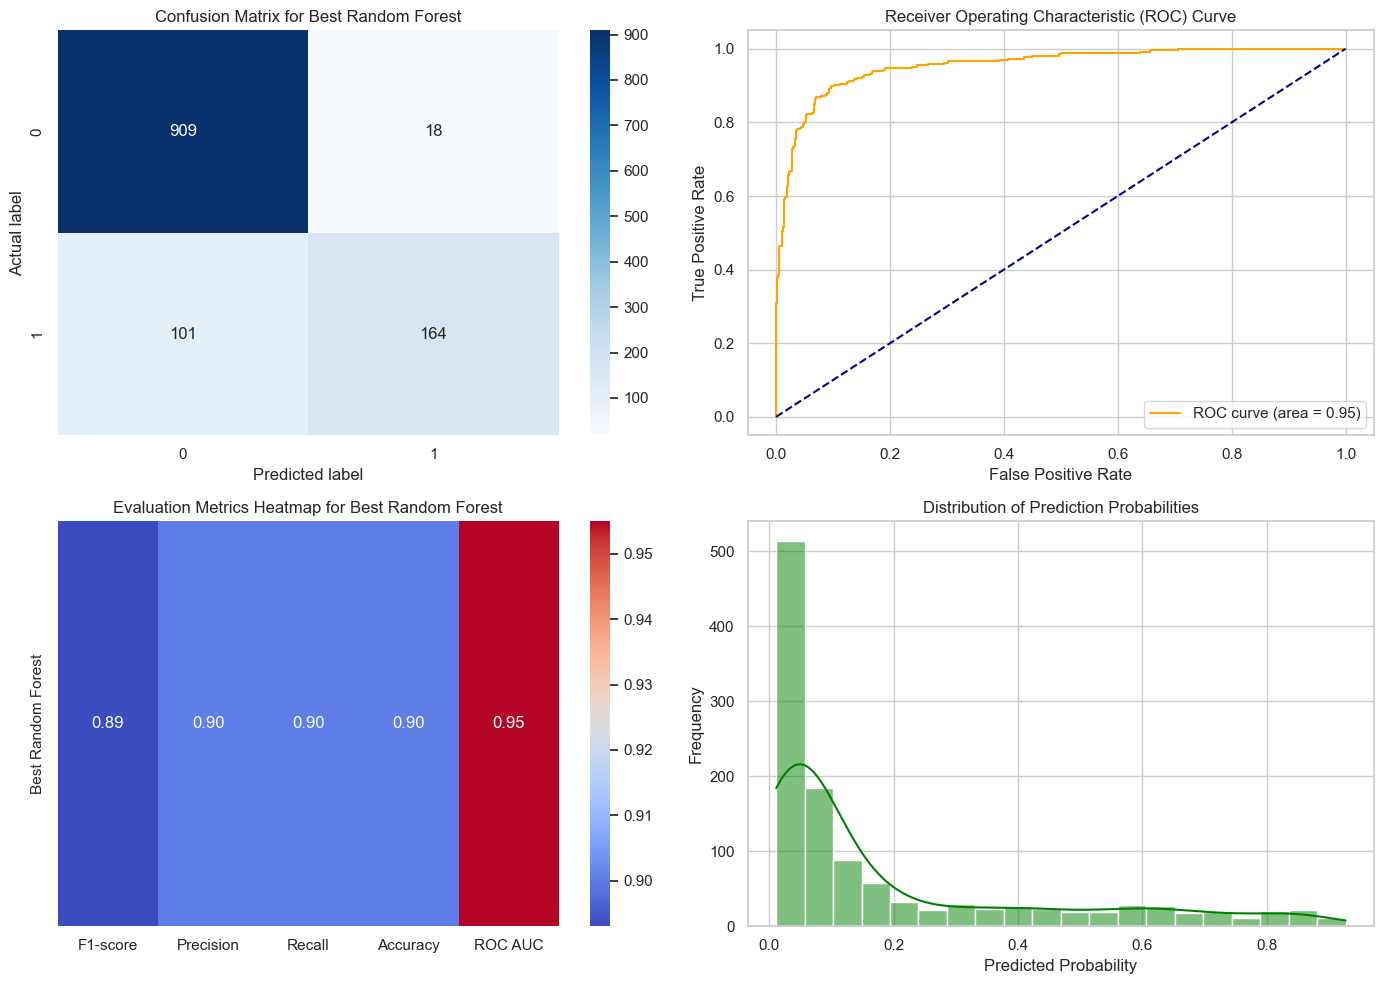

{'F1-score': 0.8930381398851288, 'Precision': 0.9002443026771886, 'Recall': 0.9001677852348994, 'Accuracy': 0.9001677852348994, 'ROC AUC': 0.9549571553601596}


In [95]:
from sklearn.model_selection import GridSearchCV

# Định nghĩa các giá trị của siêu tham số để tìm kiếm
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy']
}

# Tạo GridSearchCV với RandomForestClassifier
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1,
                           verbose=2)

# Tìm kiếm trên tập huấn luyện
grid_search.fit(X_train_smote, y_train_smote)

# In ra các siêu tham số tốt nhất
print("Best Parameters:", grid_search.best_params_)

# Dự đoán với mô hình tốt nhất
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

# Đánh giá mô hình
best_rf_report = classification_report(y_test, y_pred_best_rf, output_dict=True)
best_rf_confusion_matrix = confusion_matrix(y_test, y_pred_best_rf)
best_rf_roc_auc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])

best_rf_metrics = {
    'F1-score': best_rf_report['weighted avg']['f1-score'],
    'Precision': best_rf_report['weighted avg']['precision'],
    'Recall': best_rf_report['weighted avg']['recall'],
    'Accuracy': best_rf_report['accuracy'],
    'ROC AUC': best_rf_roc_auc
}

plt.figure(figsize=(14, 10))

best_metrics_df = pd.DataFrame([best_rf_metrics], index=['Best Random Forest'])

plt.subplot(2, 2, 1)
sns.heatmap(best_rf_confusion_matrix, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix for Best Random Forest")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.subplot(2, 2, 2)
fpr, tpr, _ = roc_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {best_rf_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

plt.subplot(2, 2, 3)
sns.heatmap(best_metrics_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Evaluation Metrics Heatmap for Best Random Forest")

plt.subplot(2, 2, 4)
sns.histplot(best_rf_model.predict_proba(X_test)[:, 1], kde=True, color='green', bins=20)
plt.title('Distribution of Prediction Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
print(best_rf_metrics)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


d:\anaconda3\envs\python310\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
150 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "d:\anaconda3\envs\python310\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\anaconda3\envs\python310\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "d:\anaconda3\envs\python310\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "d:\anaconda3\envs\python310\

Best Parameters: {'n_estimators': 700, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini'}


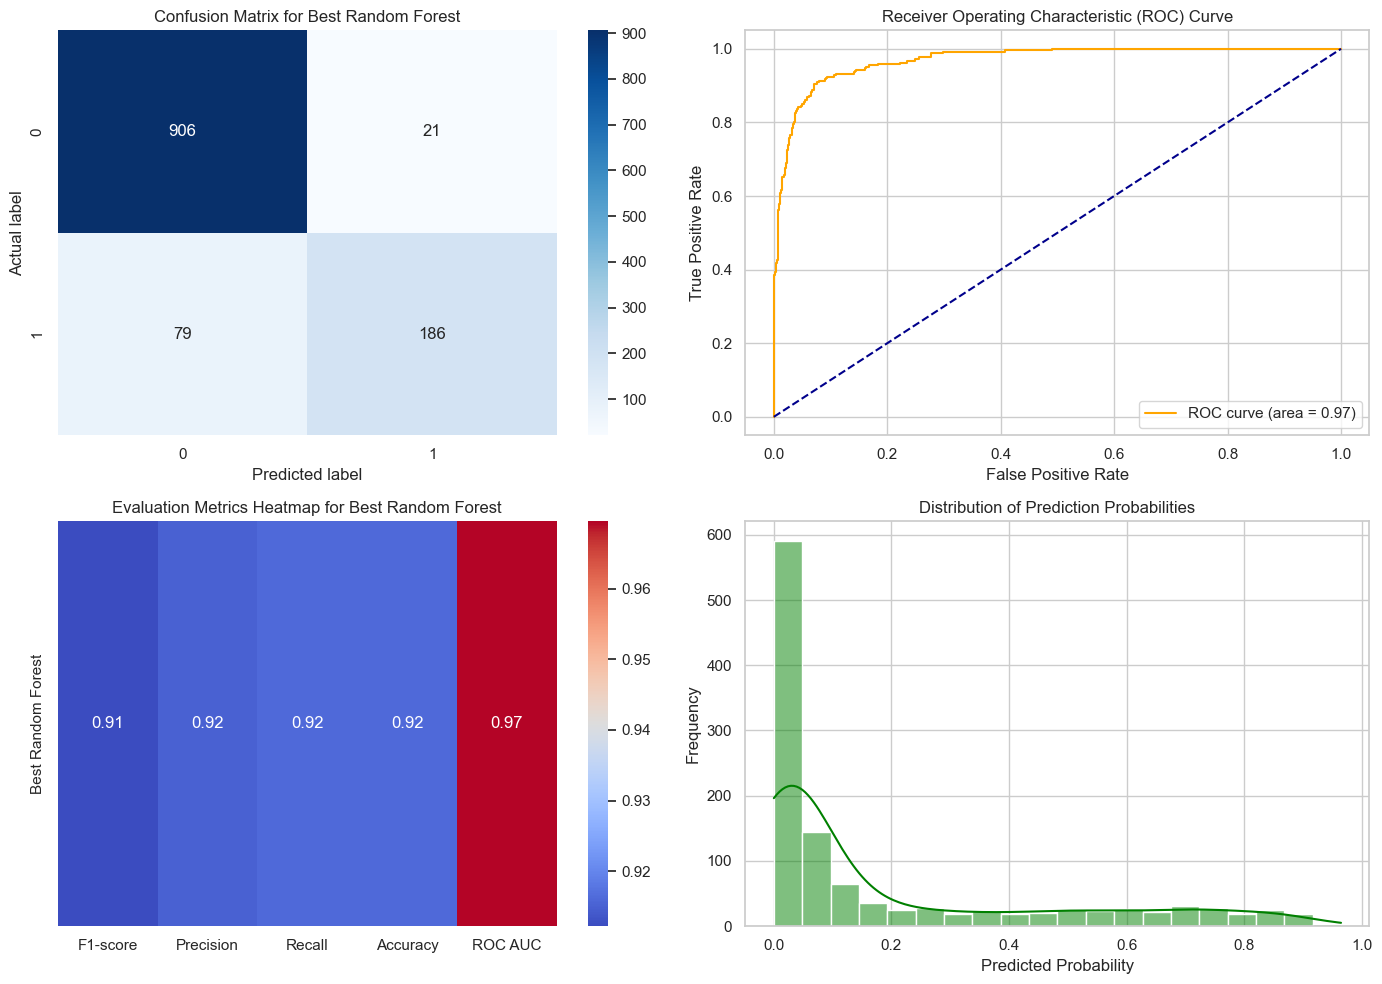

{'F1-score': 0.9122253931250531, 'Precision': 0.9150735894955804, 'Recall': 0.9161073825503355, 'Accuracy': 0.9161073825503355, 'ROC AUC': 0.9695263682807189}


In [101]:
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import pandas as pd

# Định nghĩa các giá trị của siêu tham số để tìm kiếm
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(4, 20, num=10)],
    'criterion': ['gini', 'entropy']
}

# Tạo RandomizedSearchCV với RandomForestClassifier
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=100,  # Số lần thử nghiệm ngẫu nhiên
                                   scoring='accuracy',
                                   cv=5,
                                   n_jobs=-1,
                                   verbose=2,
                                   random_state=42)

# Tìm kiếm trên tập huấn luyện
random_search.fit(X_train_smote, y_train_smote)

# In ra các siêu tham số tốt nhất
print("Best Parameters:", random_search.best_params_)

# Dự đoán với mô hình tốt nhất
best_rf_model = random_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

# Đánh giá mô hình
best_rf_report = classification_report(y_test, y_pred_best_rf, output_dict=True)
best_rf_confusion_matrix = confusion_matrix(y_test, y_pred_best_rf)
best_rf_roc_auc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])

best_rf_metrics = {
    'F1-score': best_rf_report['weighted avg']['f1-score'],
    'Precision': best_rf_report['weighted avg']['precision'],
    'Recall': best_rf_report['weighted avg']['recall'],
    'Accuracy': best_rf_report['accuracy'],
    'ROC AUC': best_rf_roc_auc
}

plt.figure(figsize=(14, 10))

best_metrics_df = pd.DataFrame([best_rf_metrics], index=['Best Random Forest'])

plt.subplot(2, 2, 1)
sns.heatmap(best_rf_confusion_matrix, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix for Best Random Forest")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.subplot(2, 2, 2)
fpr, tpr, _ = roc_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {best_rf_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

plt.subplot(2, 2, 3)
sns.heatmap(best_metrics_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Evaluation Metrics Heatmap for Best Random Forest")

plt.subplot(2, 2, 4)
sns.histplot(best_rf_model.predict_proba(X_test)[:, 1], kde=True, color='green', bins=20)
plt.title('Distribution of Prediction Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
print(best_rf_metrics)


***Tunning model bằng Random Search***

In [102]:
import joblib

joblib.dump(best_rf_model, 'best_rf_model.pkl')

['best_rf_model.pkl']

**4.2 Decision Tree**

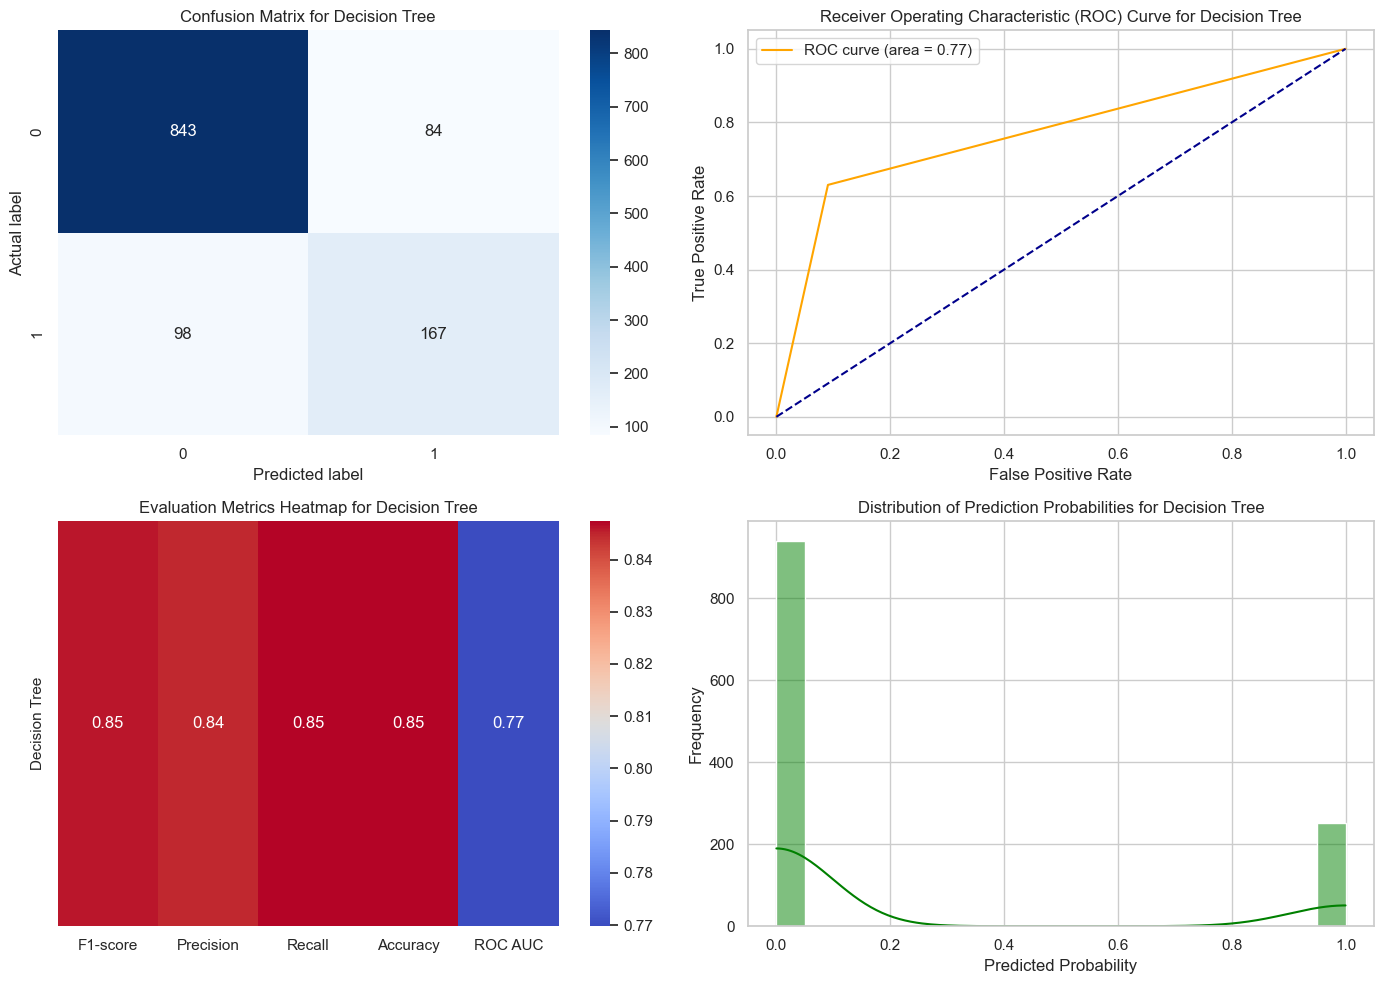

{'F1-score': 0.8458162924495837, 'Precision': 0.8446080238382887, 'Recall': 0.8473154362416108, 'Accuracy': 0.8473154362416108, 'ROC AUC': 0.7697868962569457}


In [96]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_smote, y_train_smote)

y_pred_dt = dt_model.predict(X_test)

dt_report = classification_report(y_test, y_pred_dt, output_dict=True)
dt_confusion_matrix = confusion_matrix(y_test, y_pred_dt)
dt_roc_auc = roc_auc_score(y_test, dt_model.predict_proba(X_test)[:, 1])

dt_metrics = {
    'F1-score': dt_report['weighted avg']['f1-score'],
    'Precision': dt_report['weighted avg']['precision'],
    'Recall': dt_report['weighted avg']['recall'],
    'Accuracy': dt_report['accuracy'],
    'ROC AUC': dt_roc_auc
}

dt_metrics_df = pd.DataFrame([dt_metrics], index=['Decision Tree'])

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.heatmap(dt_confusion_matrix, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix for Decision Tree")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.subplot(2, 2, 2)
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_model.predict_proba(X_test)[:, 1])
plt.plot(fpr_dt, tpr_dt, color='orange', label=f'ROC curve (area = {dt_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree')
plt.legend()

plt.subplot(2, 2, 3)
sns.heatmap(dt_metrics_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Evaluation Metrics Heatmap for Decision Tree")

plt.subplot(2, 2, 4)
sns.histplot(dt_model.predict_proba(X_test)[:, 1], kde=True, color='green', bins=20)
plt.title('Distribution of Prediction Probabilities for Decision Tree')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(dt_metrics)

In [103]:
import joblib

# Lưu mô hình tốt nhất
joblib.dump(dt_metrics, 'dt_model.pkl')

['dt_model.pkl']

**4.3 SVM**

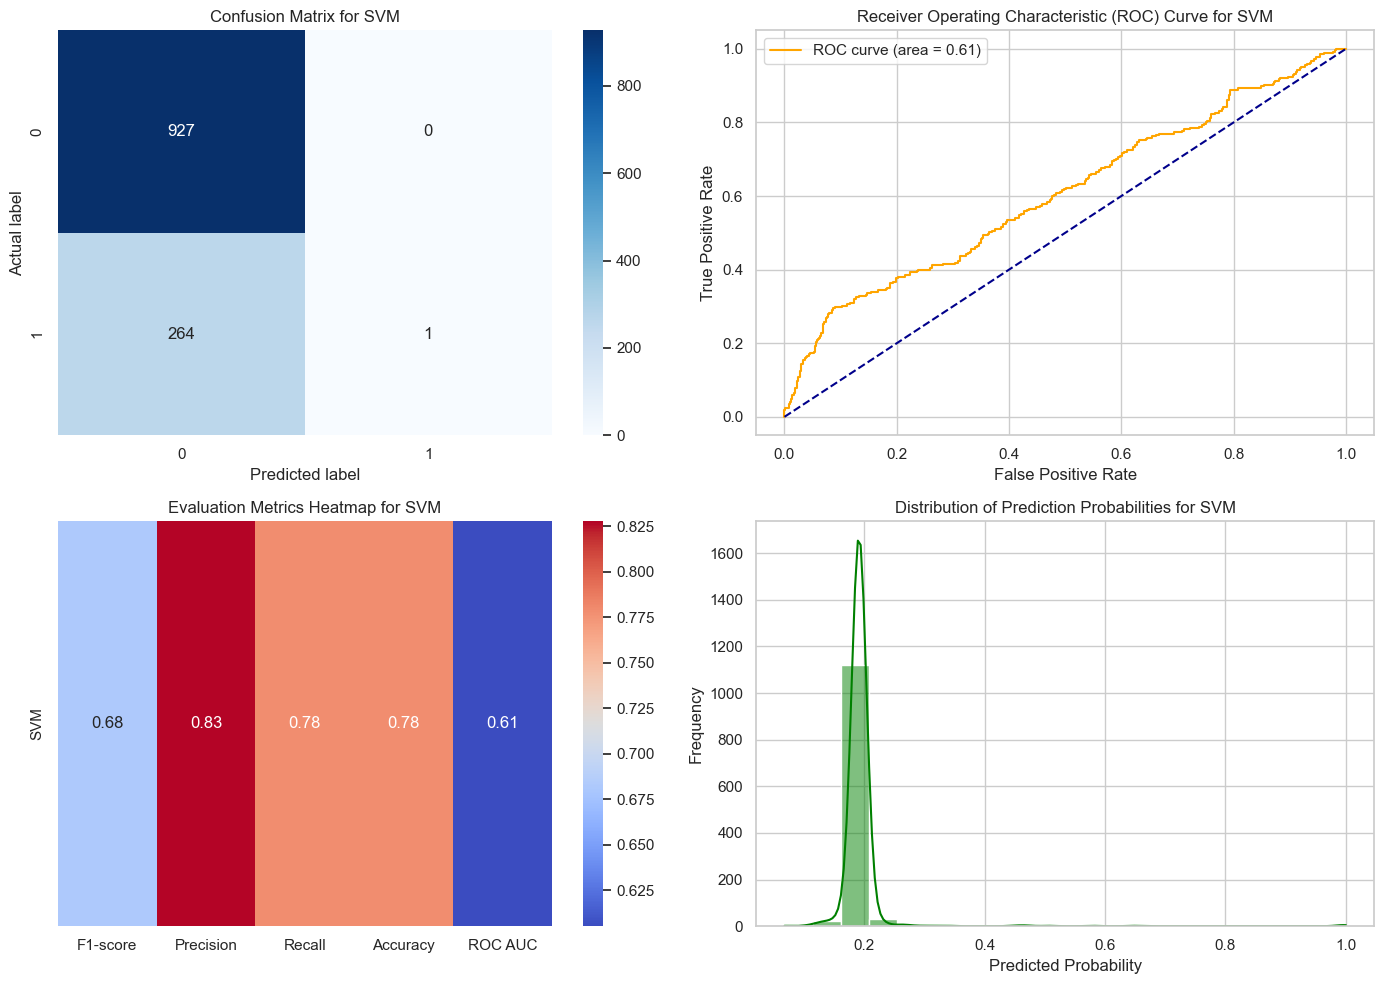

{'F1-score': 0.6824209219743086,
 'Precision': 0.8276165198721959,
 'Recall': 0.7785234899328859,
 'Accuracy': 0.7785234899328859,
 'ROC AUC': 0.6052471962711934}

In [97]:
from sklearn.svm import SVC

svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_smote, y_train_smote)

y_pred_svm = svm_model.predict(X_test)

svm_report = classification_report(y_test, y_pred_svm, output_dict=True)
svm_confusion_matrix = confusion_matrix(y_test, y_pred_svm)
svm_roc_auc = roc_auc_score(y_test, svm_model.predict_proba(X_test)[:, 1])

svm_metrics = {
    'F1-score': svm_report['weighted avg']['f1-score'],
    'Precision': svm_report['weighted avg']['precision'],
    'Recall': svm_report['weighted avg']['recall'],
    'Accuracy': svm_report['accuracy'],
    'ROC AUC': svm_roc_auc
}

svm_metrics_df = pd.DataFrame([svm_metrics], index=['SVM'])

# Membuat visualisasi
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.heatmap(svm_confusion_matrix, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix for SVM")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.subplot(2, 2, 2)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_model.predict_proba(X_test)[:, 1])
plt.plot(fpr_svm, tpr_svm, color='orange', label=f'ROC curve (area = {svm_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SVM')
plt.legend()

plt.subplot(2, 2, 3)
sns.heatmap(svm_metrics_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Evaluation Metrics Heatmap for SVM")

plt.subplot(2, 2, 4)
sns.histplot(svm_model.predict_proba(X_test)[:, 1], kde=True, color='green', bins=20)
plt.title('Distribution of Prediction Probabilities for SVM')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

svm_metrics

In [104]:
import joblib

joblib.dump(svm_metrics, 'svm_model.pkl')

['svm_model.pkl']

**4.4 KNN**

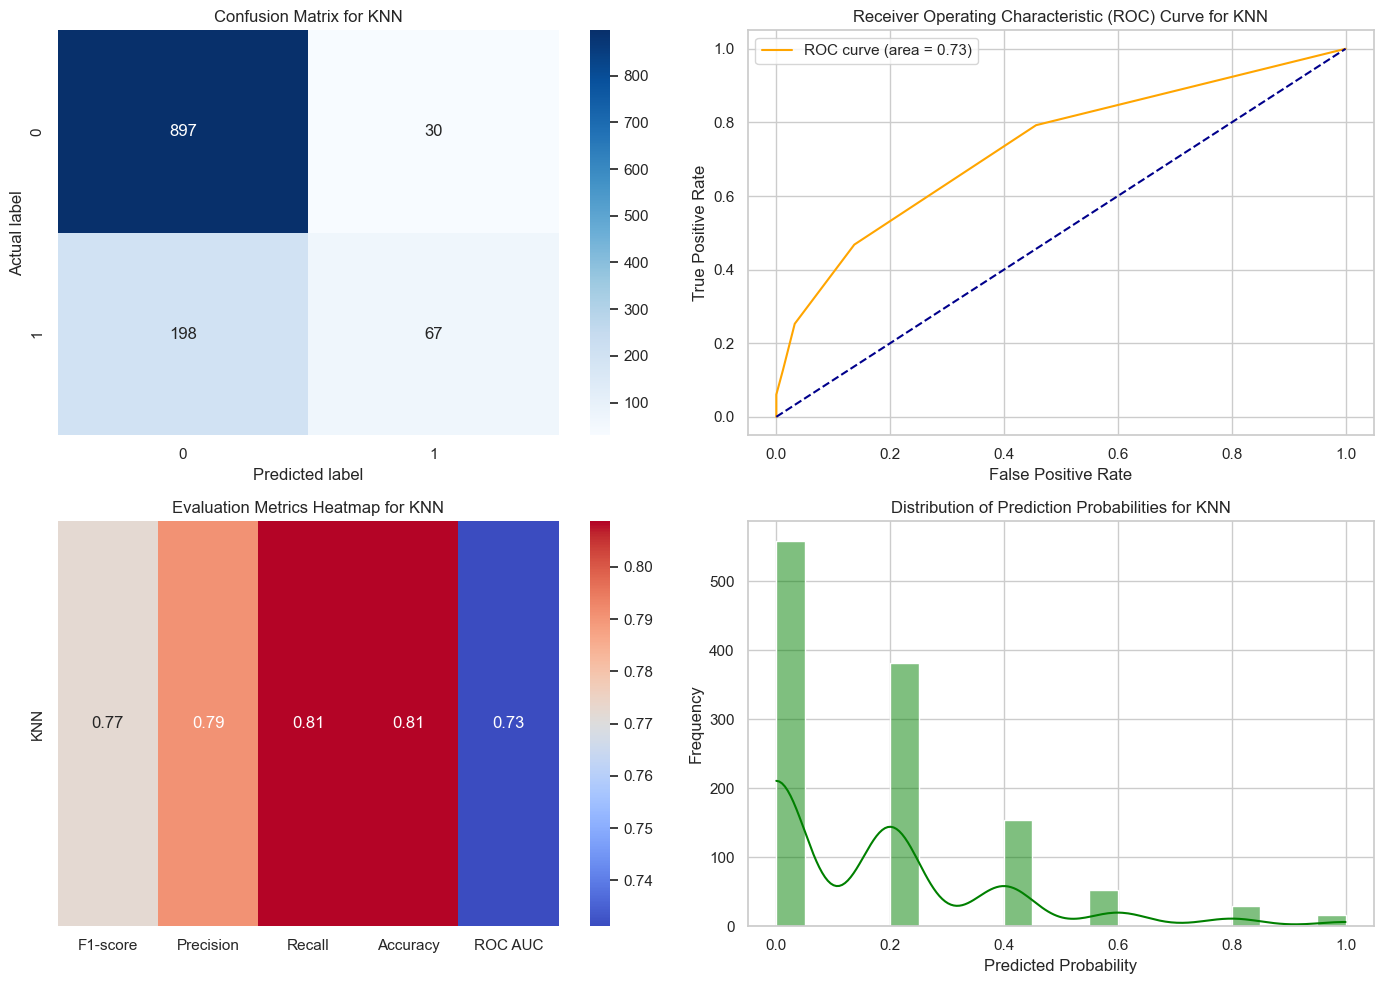

{'F1-score': 0.7722866885410692,
 'Precision': 0.7906202343164286,
 'Recall': 0.8087248322147651,
 'Accuracy': 0.8087248322147651,
 'ROC AUC': 0.731228755775376}

In [98]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_train_smote, y_train_smote)

y_pred_knn = knn_model.predict(X_test)

knn_report = classification_report(y_test, y_pred_knn, output_dict=True)
knn_confusion_matrix = confusion_matrix(y_test, y_pred_knn)
knn_roc_auc = roc_auc_score(y_test, knn_model.predict_proba(X_test)[:, 1])

knn_metrics = {
    'F1-score': knn_report['weighted avg']['f1-score'],
    'Precision': knn_report['weighted avg']['precision'],
    'Recall': knn_report['weighted avg']['recall'],
    'Accuracy': knn_report['accuracy'],
    'ROC AUC': knn_roc_auc
}

knn_metrics_df = pd.DataFrame([knn_metrics], index=['KNN'])

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.heatmap(knn_confusion_matrix, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix for KNN")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.subplot(2, 2, 2)
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_model.predict_proba(X_test)[:, 1])
plt.plot(fpr_knn, tpr_knn, color='orange', label=f'ROC curve (area = {knn_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for KNN')
plt.legend()

plt.subplot(2, 2, 3)
sns.heatmap(knn_metrics_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Evaluation Metrics Heatmap for KNN")

plt.subplot(2, 2, 4)
sns.histplot(knn_model.predict_proba(X_test)[:, 1], kde=True, color='green', bins=20)
plt.title('Distribution of Prediction Probabilities for KNN')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

knn_metrics

In [105]:
import joblib

joblib.dump(knn_metrics, 'knn_model.pkl')

['knn_model.pkl']

**4.5 Total**

In [106]:

metrik_kesimpulan = pd.DataFrame({
    'Random Forest': best_rf_metrics,
    'Decision Tree': dt_metrics,
    'SVM': svm_metrics,
    'KNN': knn_metrics,
})

metrik_kesimpulan = metrik_kesimpulan.T

metrik_kesimpulan

,F1-score,Precision,Recall,Accuracy,ROC AUC
Random Forest,0.912225,0.915074,0.916107,0.916107,0.969526
Decision Tree,0.845816,0.844608,0.847315,0.847315,0.769787
SVM,0.682421,0.827617,0.778523,0.778523,0.605247
KNN,0.772287,0.790620,0.808725,0.808725,0.731229
